# Morphological Inflection by Prefix-Suffix-Rule prediction

This approach to morphological inflection generation works in the following way: For given lemma and morphological tags, predict the form's prefix to be substituted by another prefix and the form's suffix to be substituted by another suffix.

We extract allowed substitution rules from the training data.

## 1. Prefix-Suffix rule extraction

In [1]:
import re
import numpy as np

Given a pair (form, lemma), we extract the according prefix and suffix substitution as follows: First, align the form and the lemma by their longest common infix. Then, treat the parts of lemma and form preceding the aligned infix as prefixes to substitute and the parts following the aligned infix as suffixes to substitute.

In [2]:
def longest_common_prefix(s1: str, s2: str):
    """Returns the length of longest common prefix of strings `s1` and `s2"""
    common_prefix_length = 0
    
    # Count how many initial letters are the same for both strings
    for c1, c2 in zip(s1, s2):
        if c1 == c2:
            common_prefix_length += 1
        # Stop counting at first different letter
        else:
            break
    
    return common_prefix_length

In [3]:
def align_by_longest_common_infix(w1:str, w2:str):
    """
    Align strings w1 and w2 by their longest common infix.
    Return starting indices of longest common infix in w1 and w2 and length of the longest common infix.
    """
    # Initialise scoring matrix
    cost_matrix = np.zeros((len(w1), len(w2)), dtype=np.int16)
    
    # Populate scoring matrix for indices:
    # For each combination of possible starting indices in w1 and w2, we calculate the
    # longest common prefix length of substrings starting at the respective indices
    for i in range(len(w1)):
        for j in range(len(w2)):
            cost_matrix[i, j] = longest_common_prefix(w1[i:], w2[j:])
    
    # Find & return indices
    best_indices = np.argmax(cost_matrix)
    best_i, best_j = np.unravel_index(best_indices, cost_matrix.shape)
    longest_infix_length = cost_matrix[best_i, best_j].item()
    
    return best_i, best_j, longest_infix_length

In [4]:
def get_rule(lemma: str, form: str):
    """Given lemma and form, find suffix and prefix to substitute"""
    # Align by longest common infix
    i, j, l = align_by_longest_common_infix(lemma, form)
    # Extract suffixes and prefixes
    prefix_lemma, suffix_lemma = lemma[:i], lemma[i+l:]
    prefix_form, suffix_form = form[:j], form[j+l:]
    
    # Return rule
    return ((prefix_lemma, prefix_form), (suffix_lemma, suffix_form))

## 2. Data exploration

We need to get a feeling for how many rules are generated for each language. This can indicate whether this approach is useful in general. Languages where morphological inflection is not based on prefix or suffix manipulation will likely generate a very high number of rules that don't generalise well.

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange

First, we generate a list of all languages in the data:

In [6]:
language_codes = set()

for filename in os.listdir("part1/development_languages/"):
    code, extension = filename.split('.')
    language_codes.add(code)

language_codes = list(sorted(language_codes))

Then, we generate the rule dataset from the train portion of all languages:

In [7]:
rule_statistics = []
# Save the rules for training (later)
training_data = dict()

for language_code in tqdm(language_codes):
    # Read training data
    path = f"part1/development_languages/{language_code}.train"
    data = pd.read_csv(path, sep='\t', names=["lemma", "form", "tag"])
    
    # Extract lemmas, forms, and tags
    lemmas = data["lemma"].tolist()
    forms = data["form"].tolist()
    tags = data["tag"].tolist()
    
    # Generate all rules
    language_dataset = []
    language_rules = set()
    # Iterate over all lemma, form, tag triples
    for lemma, form, tag in zip(lemmas, forms, tags):
        # Generate rule
        lemma, form, tag = str(lemma), str(form), str(tag)
        rule = get_rule(lemma, form)
        # Save data & rule
        language_dataset.append((lemma, tag, form, rule))
        language_rules.add(rule)
        
    training_data[language_code] = language_dataset
    
    num_rules = len(language_rules)
    num_words_in_language = len(language_dataset)
    relative_num_rules = 100 * (num_rules / num_words_in_language)
    rule_statistics.append([language_code, num_rules, num_words_in_language, relative_num_rules])

rule_statistics = pd.DataFrame(rule_statistics, columns=["Language", "#Rules", "#Words", "%Rules"])

  0%|          | 0/35 [00:00<?, ?it/s]

Here, we show the absolute numbers of generated rules per language:

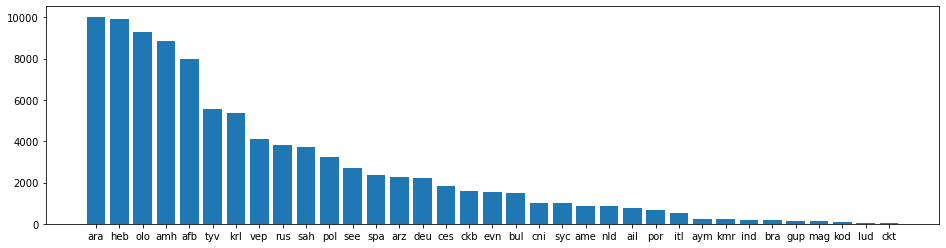

In [8]:
rule_statistics.sort_values('#Rules', inplace=True, ascending=False)

num_rules = rule_statistics['#Rules'].astype(np.int64)
languages = rule_statistics['Language']

plt.figure(figsize=(16, 4))
plt.bar(languages, num_rules)
plt.show()

We also show the relative numbers of generated rules per language:

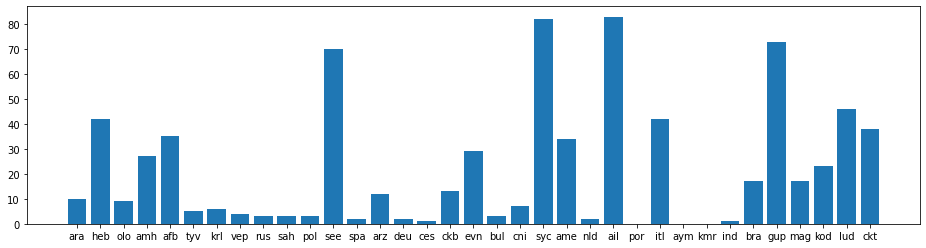

In [9]:
num_rules = rule_statistics['%Rules'].astype(np.int64)
languages = rule_statistics['Language']

plt.figure(figsize=(16, 4))
plt.bar(languages, num_rules)
plt.show()

We can see that the absolute number of generated rules does not correlate much with the relative number of generated rules.

Finally, we also show the distribution of relative numbers of generated rules:

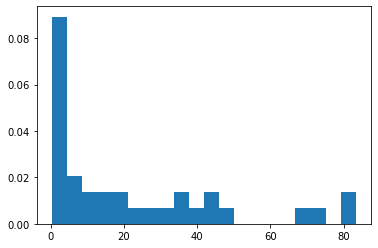

In [10]:
rule_ratios = rule_statistics["%Rules"].to_numpy()

plt.hist(rule_ratios, bins=20, density=True)
plt.show()

We can see that for most languages, the number of generated rules is less than 20% of the number of forms in the data. However, there is still a reasonable number where the ration is higher, so we expect a number of languages where our approach fails.

## 3. Defining a rule classification model

Having generated the possible prefix-suffix-rules for a language, we can approach morphological inflection as a multiclass classification problem: Given a lemma and a sequence of morphological tags, predict the rule to apply to the lemma in order to generate the correct form.

For this we can train a classifier in a supervised fashion. Our model works as follows: First, we encode tags and lemma indendently. The lemma is encoded by two layers of character convolutions with GELU nonlinearities followed by feature-wise max pooling to arrive at a single vector representation for the lemma. The tags are encoded by a bag-of-embeddings model (summing the embeddings of all tags) followed by a single nonlinear projection. Finally, the lemma encoding and the tag sequence encoding are added. We predict the rule passing the added lemma and tag sequence encoding through a MLP classifier.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [12]:
class RuleClassifierInflection(nn.Module):
    def __init__(self, num_chars: int, num_tags: int, num_rules: int, embedding_size: int,
                 hidden_size: int, ngram: int = 3):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Initialise embeddings of characters & tags
        self.char_embedding = nn.Embedding(num_chars, embedding_size, padding_idx=0)
        self.tag_embedding = nn.EmbeddingBag(num_tags, embedding_size, padding_idx=0, mode='sum')
        
        # Convnet for lemma encoding
        self.conv = nn.Sequential(
            nn.Conv1d(embedding_size, hidden_size, ngram, padding='same'),
            nn.GELU(),
            nn.Conv1d(hidden_size, hidden_size, ngram, padding='same')
        )
        
        # Nonlinear projection of tag sequence representation
        self.tag_project = nn.Sequential(
            nn.Linear(embedding_size, hidden_size),
            nn.GELU()
        )
        
        # Classifier MLP
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_rules)
        )
        
    @staticmethod
    def get_mask(lengths: torch.Tensor):
        """Generate a binare mask of shape batch x timesteps with 1 meaning padding chars"""
        with torch.no_grad():
            max_length = torch.max(lengths).item()
            mask = torch.arange(max_length)
            mask = mask.unsqueeze(0).tile((len(lengths), 1))
            mask = (mask >= lengths.unsqueeze(1))
            return mask
    
    def forward(self, lemma: torch.Tensor, tags: torch.Tensor):
        # Calculate length of each lemma in the minibatch
        batch, length = lemma.shape
        lengths = (lemma != 0).sum(dim=1).flatten().long()
        
        # Embed and project morphological tags
        tag_embedded = self.tag_embedding(tags)
        tag_encoded = self.tag_project(tag_embedded)
        
        # Embed and encode lemma
        char_embedded = self.char_embedding(lemma)
        char_embedded = char_embedded.transpose(1, 2)
        char_encoded = self.conv(char_embedded)
        char_encoded = char_encoded.transpose(1, 2)
        
        # Mask all padded chars in the lemma encoding before max-pooling
        mask = self.get_mask(lengths)
        mask = mask.unsqueeze(2).tile((1, 1, char_encoded.shape[2]))
        char_encoded = torch.masked_fill(char_encoded, mask, -np.inf)
        
        # Get single vector encoding by feature-wise max pooling
        char_encoded = torch.amax(char_encoded, dim=1)
        
        # Add lemma and tag encodings
        y_pred = char_encoded + tag_encoded
        # Predict rule
        y_pred = self.classifier(y_pred)
        
        return y_pred

## 4. Define data indexing and the training loop

In [13]:
from torch.optim import SGD
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_value_
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import OneCycleLR

In [14]:
def update_loss(old_loss, new_loss, gamma=0.95):
    if old_loss is not None:
        return gamma * old_loss + (1-gamma) * new_loss
    else:
        return new_loss

In [15]:
class RuleClassifierModel:
    def __init__(self, embedding_size: int, hidden_size: int, ngram: int = 3, batch_size: int = 4,
                 max_lr: float = 0.01, num_steps: int = 3000):
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.ngram = ngram
        
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.max_lr = max_lr
    
    def init_classifier(self):
        """Setup rule classifier"""
        self.model = RuleClassifierInflection(
            len(self.char_vocabulary) + 1,
            len(self.tag_vocabulary) + 1,
            len(self.rule_vocabulary) + 1,
            self.embedding_size,
            self.hidden_size,
            ngram = self.ngram
        )
        self.model.train()
        
        # Setup optimizer and loss function
        self.optimizer = SGD(self.model.parameters(), lr=0.001)
        self.criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    def make_indexer(self, words, tags, rules):
        self.pad = "<PAD>"
        self.unk = "<UNK>"
        self.specials = [self.pad, self.unk]
        self.char_vocabulary = self.specials + list(sorted(set.union(*map(set, words))))
        self.rule_vocabulary = self.specials + list(sorted(set(rules)))
        self.tag_vocabulary = self.specials + list(sorted(set.union(*map(set, tags))))
        
        self.idx2char = dict(enumerate(self.char_vocabulary))
        self.idx2rule = dict(enumerate(self.rule_vocabulary))
        self.idx2tag = dict(enumerate(self.tag_vocabulary))
        
        self.char2idx = {char: idx for idx, char in self.idx2char.items()}
        self.rule2idx = {rule: idx for idx, rule in self.idx2rule.items()}
        self.tag2idx = {tag: idx for idx, tag in self.idx2tag.items()}
    
    def index_dataset(self, words, tags, rules=None):
        indexed_words = [[self.char2idx.get(c, 1) for c in word] for word in words]
        indexed_tags = [[self.tag2idx.get(subtag, 1) for subtag in tag] for tag in tags]
        
        if rules is not None:
            indexed_rules = list(map(self.rule2idx.get, rules))
            dataset = list(zip(indexed_words, indexed_tags, indexed_rules))
        else:
            dataset = list(zip(indexed_words, indexed_tags))
            
        return dataset
    
    @staticmethod
    def collate_fn_train(batch):
        words, tags, rules = zip(*batch)
        words = [torch.LongTensor(word) for word in words]
        words = pad_sequence(words, batch_first=True)
    
        tags = [torch.LongTensor(tag) for tag in tags]
        tags = pad_sequence(tags, batch_first=True)
    
        rules = torch.LongTensor(rules).flatten()
    
        return words, tags, rules
    
    @staticmethod
    def collate_fn_eval(batch):
        words, tags = zip(*batch)
        words = [torch.LongTensor(word) for word in words]
        words = pad_sequence(words, batch_first=True)
    
        tags = [torch.LongTensor(tag) for tag in tags]
        tags = pad_sequence(tags, batch_first=True)
    
        return words, tags
    
    def get_applicable_rules(self, word):
        """Find all prefix-suffix rules that apply to given lemma"""
        applicable_idx = []
        for rule, index in self.rule2idx.items():
            prefix_lemma = rule[0][0]
            suffix_lemma = rule[1][0]
            
            if (
                word.startswith(prefix_lemma) and
                word.endswith(suffix_lemma) and
                len(prefix_lemma) + len(suffix_lemma) <= len(word)
            ):
                applicable_idx.append(index)
        
        return applicable_idx
    
    @staticmethod
    def apply_rule(word, rule):
        """Apply rule to lemma"""
        ((prefix_lemma, prefix_form), (suffix_lemma, suffix_form)) = rule
        stem = word[len(prefix_lemma):len(word)-len(suffix_lemma)]
        return prefix_form + stem + suffix_form
    
    def predict(self, words, tags):
        tags = [tag.split(';') for tag in tags]
        
        dataset = self.index_dataset(words, tags)
        dataset = DataLoader(dataset, batch_size = self.batch_size,
                             collate_fn = self.collate_fn_eval, shuffle = False)
        
        predictions = []
        prediction_scores = []
        
        for word, tag in tqdm(dataset):
            with torch.no_grad():
                y_pred = self.model(word, tag)
            
            y_pred = y_pred.detach().cpu().numpy()
            prediction_scores.append(y_pred)
        
        prediction_scores = np.concatenate(prediction_scores, axis=0)
        
        for word, scores in zip(words, prediction_scores):
            applicable_idx = self.get_applicable_rules(word)
            
            if len(applicable_idx) == 0:
                predictions.append(word)

            else:
                applicable_scores = scores[applicable_idx]
                best_score_idx = np.argmax(applicable_scores)
                rule_idx = applicable_idx[best_score_idx]
                rule = self.idx2rule[rule_idx]
                predictions.append(self.apply_rule(word, rule))
    
        return predictions
                
    def fit(self, words, forms, tags):
        tags = [tag.split(';') for tag in tags]
        rules = [get_rule(str(lemma), str(form)) for lemma, form in zip(words, forms)]
        
        self.make_indexer(words, tags, rules)
        self.init_classifier()
        dataset = self.index_dataset(words, tags, rules)
        dataset = DataLoader(dataset, batch_size = self.batch_size,
                             collate_fn = self.collate_fn_train, shuffle = True)
        
        epochs = round(self.num_steps / len(dataset))
        
        scheduler = OneCycleLR(self.optimizer, max_lr = self.max_lr, epochs = epochs,
                               steps_per_epoch = len(dataset))
        
        running_loss = None
        pbar = tqdm(total = epochs * len(dataset))
        
        for epoch in range(epochs):
            for batch in dataset:
                self.optimizer.zero_grad()
                
                word, tag, rule = batch
                y_pred = self.model(word, tag)
                
                loss = self.criterion(y_pred, rule)
                
                loss.backward()
                clip_grad_value_(self.model.parameters(), 5.0)
                self.optimizer.step()
                scheduler.step()
                
                detached_loss = loss.detach().cpu().item()
                running_loss = update_loss(running_loss, detached_loss)
                
                pbar.update(1)
                pbar.set_postfix_str(f"Loss: {detached_loss:.2f}, Running Loss: {running_loss:.4f}")
            
            if running_loss < 0.001:
                break

In [16]:
from sklearn.metrics import accuracy_score

def evaluate_language(code):
    train_path = f"part1/development_languages/{code}.train"
    train_data = pd.read_csv(train_path, sep='\t', names=["lemma", "form", "tag"])
    train_data = train_data.dropna()

    eval_path = f"part1/development_languages/{code}.dev"
    eval_data = pd.read_csv(eval_path, sep='\t', names=["lemma", "form", "tag"])
    eval_data = eval_data.dropna()
    
    train_lemmas = train_data["lemma"].tolist()
    train_forms = train_data["form"].tolist()
    train_tags = train_data["tag"].tolist()

    classifier = RuleClassifierModel(32, 256, batch_size=128, ngram=5, max_lr=0.1)
    classifier.fit(train_lemmas, train_forms, train_tags)
    
    eval_lemmas = eval_data["lemma"].tolist()
    eval_forms = eval_data["form"].tolist()
    eval_tags = eval_data["tag"].tolist()
    
    predicted_forms = classifier.predict(eval_lemmas, eval_tags)
    
    accuracy = accuracy_score(predicted_forms, eval_forms)
    return accuracy

Now we can train a model for every language and evaluate on the test set:

In [17]:
results = []

# for language_code in language_codes:
#    print(f"Current language is: {language_code}")
#    accuracy = evaluate_language(language_code)
#    results.append([language_code, accuracy])
#    print()

# results = pd.DataFrame(results, columns=["Language", "Accuracy"])
# results.to_csv("results.csv")

In [20]:
results = pd.read_csv('results.csv', index_col=0)

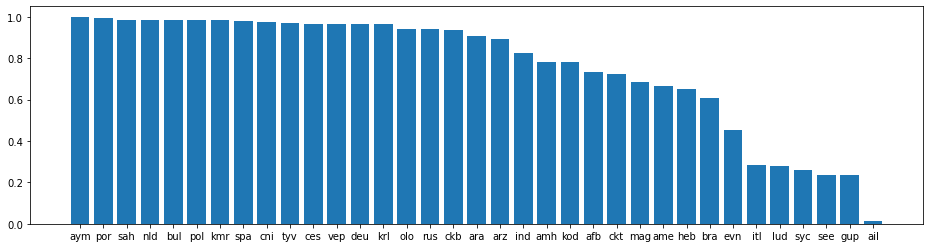

In [24]:
results.sort_values('Accuracy', ascending=False, inplace=True)

accuracies = results['Accuracy'].astype(np.float64)
languages = results['Language']

plt.figure(figsize=(16, 4))
plt.bar(languages, accuracies)
plt.show()

We can see that the approach works quite well for some languages, but not so well for others.